# Noise Mitigation on Multiple Pauli-X Gate Pairs:

## Circuit:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools import visualization as qplt

import NoisyQuantumCircuit as NoisyQuantumCircuit

In [2]:
from qiskit import Aer
import qiskit.providers.aer as aer
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator

In [3]:
# Import the noise model object
from qiskit.providers.aer.noise import NoiseModel

# Import all standard errors
from qiskit.providers.aer.noise.errors import *  

# Import noise base clases
from qiskit.providers.aer.noise.errors.quantum_error import QuantumError
from qiskit.providers.aer.noise.errors.readout_error import ReadoutError

In [4]:
def xSimPairs(gatePairCount, qReg, bitIdx, qNoisyCirc):

    # Perform [count] pairs of hadarmards - should ideally equal to the identity
    for i in range(gatePairCount):
        qNoisyCirc.x(qReg[bitIdx])
        qNoisyCirc.x(qReg[bitIdx])

In [5]:
def CompileAndSimulate(gatePairCount, nQubits, bitIdx, errors1Qubit, errors2Qubit, numShots = 1024, debug = False):
    
    # Simulator, and constants
    qSimulator = QasmSimulator() 
    
    # System Specification
    qReg = QuantumRegister(nQubits)
    cReg = ClassicalRegister(nQubits)
    qNoisyCirc = NoisyQuantumCircuit.NoisyQuantumCircuit(qReg, cReg, nQubits, errors1Qubit, errors2Qubit)
    
    # Perform the X's
    xSimPairs(gatePairCount = gatePairCount, qReg = qReg, bitIdx = bitIdx, qNoisyCirc = qNoisyCirc)
    
    # Measure
    qNoisyCirc.measure(qReg, cReg)
    
    # Debug: Print the error model and plot the circuit
    if(debug):
        print("Errors: ")
        for errors in zip(errors1Qubit, errors2Qubit):
            print(errors)
        #print(qNoisyCirc.draw())
    
    # Execute the noisy simulation
    result = qiskit.execute(qNoisyCirc, qSimulator, shots=numShots, 
                           basis_gates = qNoisyCirc.getNoiseModel().basis_gates,
                           noise_model = qNoisyCirc.getNoiseModel()).result()
    counts = result.get_counts(0)

    if(debug):
        print(counts)
    
    return counts

## Try with one simulation - Thermal Relaxation T1 noise

Errors: 
(QuantumError([([{'name': 'kraus', 'qubits': [0], 'params': [array([[1.        , 0.        ],
       [0.        , 0.99739922]]), array([[0.        , 0.07207492],
       [0.        , 0.        ]])]}], 1)]), QuantumError([([{'name': 'kraus', 'qubits': [0, 1], 'params': [array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.99739922, 0.        , 0.        ],
       [0.        , 0.        , 0.99739922, 0.        ],
       [0.        , 0.        , 0.        , 0.99480521]]), array([[0.        , 0.        , 0.07207492, 0.        ],
       [0.        , 0.        , 0.        , 0.07188746],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]]), array([[0.        , 0.07207492, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.07188746],
       [0.        , 0.        , 0.        , 0.        ]]), array([[0.        , 0.        , 

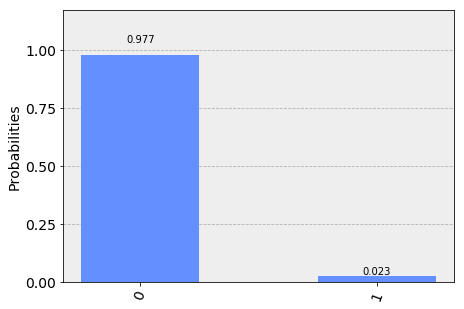

In [6]:
T1 = 12000  # nanoseconds
T2 = T1 * 2 # nanoseconds
Tau0 = 50   # nanoseconds    
pulseWidth = 1.25*Tau0

thermalError1bit = thermal_relaxation_error(T1, T2, pulseWidth)
thermalError2bit = thermal_relaxation_error(T1, T2, pulseWidth).kron(
                    thermal_relaxation_error(T1, T2, pulseWidth))


counts = CompileAndSimulate(gatePairCount = 5, nQubits = 1, bitIdx = 0, debug = True, 
                            errors1Qubit = [thermalError1bit], errors2Qubit = [thermalError2bit])

print(counts)
qplt.plot_histogram(counts)

## Multiple Simulations

1.0
0.96044921875
0.919921875
0.8896484375
0.86279296875
0.83251953125
0.810546875
0.78759765625
0.765869140625
0.734375
0.715087890625
0.703857421875
0.677001953125
0.6708984375
0.65673828125
0.64599609375
0.61865234375
0.62158203125
0.61083984375
0.584228515625
1.0
0.954345703125
0.906494140625
0.8564453125
0.843505859375
0.806396484375
0.7666015625
0.75048828125
0.713623046875
0.693359375
0.675537109375
0.66357421875
0.658203125
0.616943359375
0.62255859375
0.611328125
0.60107421875
0.583984375
0.5634765625
0.5615234375
1.0
0.922607421875
0.865478515625
0.793701171875
0.7646484375
0.72119140625
0.690185546875
0.6552734375
0.6552734375
0.607666015625
0.60546875
0.58251953125
0.567138671875
0.561279296875
0.554443359375
0.535400390625
0.515625
0.53466796875
0.53564453125
0.515869140625
1.0
0.888916015625
0.8046875
0.740966796875
0.68408203125
0.6435546875
0.629150390625
0.594970703125
0.552734375
0.560791015625
0.550537109375
0.539306640625
0.53662109375
0.51171875
0.5234375
0.5122070

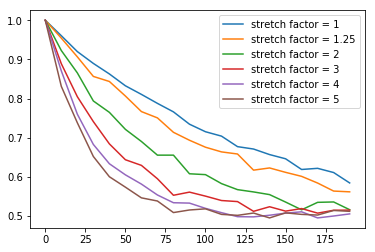

In [7]:
nPoints = 20
stretchFactors = [1, 1.25, 2, 3, 4, 5]
gatePairCounts = [x*10 for x in range(nPoints)]
yAggregator = []
numShots = 4096

for sf in stretchFactors:
    y = []
    
    for gpc in gatePairCounts:
        
        # Thermal Relaxation Error - T1
        T1 = 12000  # nanoseconds
        T2 = T1 * 2 # nanoseconds
        Tau0 = 50   # nanoseconds
        pulseWidth = sf * Tau0 
        
        thermalError1bit = thermal_relaxation_error(T1, T2, pulseWidth)
        thermalError2bit = thermal_relaxation_error(T1, T2, pulseWidth).kron(
                            thermal_relaxation_error(T1, T2, pulseWidth))
        
        counts = CompileAndSimulate(gatePairCount = gpc, nQubits = 1, bitIdx = 0, numShots = numShots,
                                    errors1Qubit = [thermalError1bit], errors2Qubit = [thermalError2bit])
        
        if(counts["0"] == None): 
            p = 0
        else:
            p = counts["0"]/numShots
            
        print(p)    
        y.append(p)
    
    yAggregator.append(y)
    plt.plot(gatePairCounts, y, label="stretch factor = {0}".format(sf))

plt.legend()
plt.show()

## Extrapolate to Maximize Noise Mitigation

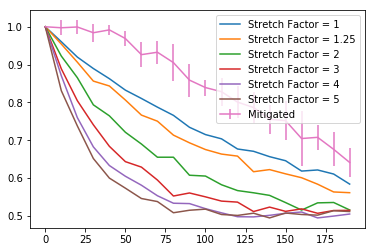

In [8]:
deg = 2

yFitted = []
errFitted = []

for j in range(nPoints):
    y = []
    for i in range(len(stretchFactors)):
        y.append(yAggregator[i][j])
        
    p, V = np.polyfit(stretchFactors, y, deg, cov = True)
    yFitted.append(np.max(p[deg], 0))
    errFitted.append(np.sqrt(V[deg][deg]))

for run in range(len(stretchFactors)):
    plt.plot(gatePairCounts, yAggregator[run], label="Stretch Factor = {0}".format(stretchFactors[run]))

plt.errorbar(gatePairCounts, yFitted, yerr=errFitted, label="Mitigated")

plt.legend()
plt.show()